# Medical Data Visualisation

Now that we've got a dataset enumerating the medical-related terms in the corpus, and their categories, we can start to analyse the fragments.

We're going to use [Vega and Vega Lite](https://vega.github.io/vega-lite/) for data visualisation, via the [Altair](https://altair-viz.github.io/) Python wrapper. Altair basically provides a Python API for generating Vega-Lite JSON visualisation description documents. Jupyter notebooks know how to render Altair objects.

In [1]:
from copy import deepcopy
from pathlib import Path
import re

import altair as alt
import altair.utils.save
from altair.vega.v3 import Vega
import pandas as pd

alt.data_transformers.enable('json')

chart_dir = Path('./charts')
chart_dir.mkdir(exist_ok=True)


# Some helpers to save vega charts
class VegaChart:
    def __init__(self, spec):
        self._spec = spec
    def to_dict(self):
        return deepcopy(self._spec)

    
def save_vega_spec(spec, filename, **options):
    "Like Chart.save() for regular Vega specs"
    defaults = {
        'vegaembed_version': '3'
    }
    
    if isinstance(spec, dict):
        json_spec = spec
        if '$schema' in spec:
            defaults['vega_version'] = re.match(r'^https://vega.github.io/schema/vega/v(\d+).json$', spec['$schema']).group(1)
    elif hasattr(spec, 'schema_path'):
        defaults['vega_version'] = re.match(r'.*\.v(\d+)\..*', spec.schema_path[0]).group(1)
        json_spec = spec.spec
    else:
        raise ValueError('Unrecognised spec')
    
    
    return altair.utils.save.save(VegaChart(json_spec), filename, **{**defaults, **options})

In [2]:
token_types = pd.read_csv('../medical-data/token-types.csv', index_col='token')
token_types.head()

,type
token,
abcess,ailment
abcesses,ailment
abdomen,body_part
abdominal,body_part
abnormal,ailment


In [3]:
fragment_tokens = pd.read_csv('../medical-data/fragment-tokens.csv')
fragment_tokens.head()

,classmark,token
0,MS-OR-01080-00001-00063,pharmacopoeia
1,MS-OR-01080-00001-00063,containing
2,MS-OR-01080-00001-00063,diagram
3,MS-OR-01080-00001-00063,and
4,MS-OR-01080-00001-00063,symbol


In [4]:
fragment_tokens = pd.merge(fragment_tokens, token_types, 
                  left_on='token', right_index=True,
                  sort=False, validate='m:1')
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [5]:
fragments = pd.read_json('../medical-data/genizah-medical.json', orient='index')
fragments.index.name = 'classmark'
fragments = fragments.reset_index()
fragments.head()

,classmark,columns,date_end,date_start,height,lines,material,summary,title,width
0,MS-OR-01080-00001-00063,1.0,1899-12-31,0500-01-01,21.2,21.0,paper,"Pharmacopoeia, containing diagrams and symbols...",Medical,14.3
1,MS-OR-01080-00001-00072,1.0,1899-12-31,0500-01-01,36.4,22.0,vellum,"Discussion of various medical treatments, regi...",Medical,16.8
2,MS-OR-01080-00001-00081,1.0,1899-12-31,0500-01-01,25.4,12.0,paper,"Medical work on the composition of the body, c...",Medical,16.8
3,MS-OR-01080-00001-00087,1.0,1233-12-31,1213-01-01,NaN,5.0,paper,Recto: a short medical recipe. Verso: a respon...,Medical,NaN
4,MS-OR-01080-00002-00070,1.0,1199-12-31,1100-01-01,31.5,35.0,paper,Autograph draft of a medical work by Moses Mai...,Medical,22.8


In [6]:
fragments.shape

(1565, 10)

## Fragment Materials

The distribution of the materials manuscripts are made from makes for an easy starting point. We can create a table of materials and the number of times they occur, and plot a bar chart using Altair:

In [7]:
material_counts = (pd.DataFrame(fragments.groupby('material').size(), columns=['count'])
    .reset_index())
material_counts

,material,count
0,cardboard,1
1,cloth,2
2,paper,1490
3,vellum,71


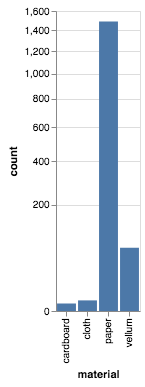

In [8]:
alt.Chart(material_counts).mark_bar().encode(
    alt.X('material:N'),
    # We'll use a non-linear scale, as the range is quite large.
    # Unfortunatley we don't get useful ticks at the bottom end
    # of the scale by default though...
    y=alt.Y('count:Q', scale=alt.Scale(type='pow', exponent=0.5)),
    tooltip='count'
)

## Fragment Sizes

Vega-Lite supports interactive charts. Each point on this scatterplot is a fragment, placed according to its width and height, and coloured according to the number of lines of text it holds. It can be panned and zoomed with a mouse.

As you'd expect, larger fragments tend to have more lines.

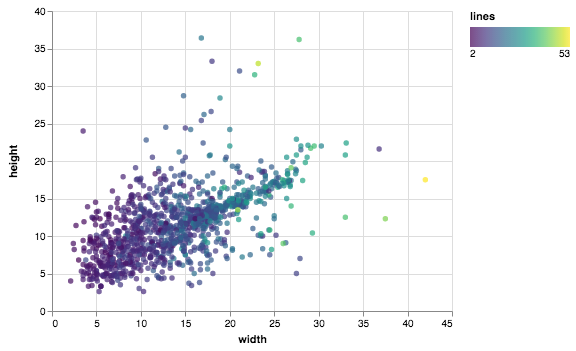

In [9]:
alt.Chart(fragments).mark_circle().encode(
    alt.X('width:Q'),
    alt.Y('height:Q'),
    color=alt.Color('lines:Q', bin=False, scale=alt.Scale(scheme='viridis')),
    tooltip='classmark'
).interactive()

## Tokens

Next let's look at our token (medical term) data.

### Token Types

First let's get a feel for how big each type category is. We'll plot the size of each category in two ways:

1. Indirectly — the number of fragments containing a token with a category
2. Directly — the number of tokens with a category

In [10]:
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [11]:
tokens_per_type = (fragment_tokens[['type', 'token']].drop_duplicates()
    .groupby(['type'])
    .count())
fragments_per_type = (fragment_tokens[['type', 'classmark']].drop_duplicates()
    .groupby(['type'])
    .count())

for df in [tokens_per_type, fragments_per_type]:
    df.rename(columns=lambda c: 'count', inplace=True)

tokens_per_type['count_type'] = 'tokens'
fragments_per_type['count_type'] = 'fragments'

token_type_counts = (pd.concat([tokens_per_type, fragments_per_type], sort=False))
token_type_counts

,count,count_type
type,,
ailment,402,tokens
authority,48,tokens
body_part,185,tokens
ingredient,466,tokens
treatment,208,tokens
ailment,799,fragments
authority,329,fragments
body_part,724,fragments
ingredient,507,fragments


In [12]:
def display_values(field=None, mapping=None, display_field_name=None):
    if display_field_name is None:
        display_field_name = f'{field}_display'
    
    lookup_frame = pd.DataFrame.from_records(list(mapping.items()), columns=[field, display_field_name])
    return alt.LookupData(data=lookup_frame, key=field, fields=[display_field_name])

In [13]:
type_display_tx = display_values('type', {
    'ailment': 'Ailment',
    'authority': 'Authority',
    'body_part': 'Body part',
    'ingredient': 'Ingredient',
    'treatment': 'Treatment'
})
count_type_display_tx = display_values('count_type', {
    'fragments': 'Fragments',
    'tokens': 'Tokens'
})

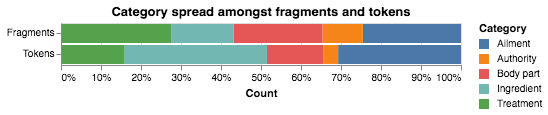

In [14]:
(alt.Chart(token_type_counts.reset_index(), title='Category spread amongst fragments and tokens')
  .mark_bar()
  .encode(
    alt.X('count:Q', axis=alt.Axis(title='Count', format='%'), stack='normalize'),
    alt.Y('count_type_display:N', axis=alt.Axis(title=None)),
    color=alt.Color('type_display:N', title='Category'),
    tooltip=['count:Q']
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
  .transform_lookup(lookup='count_type', from_=count_type_display_tx))

## Token usage frequency

Let's look at how frequently tokens occur in fragment descriptions. Are they generally used a handful of times each, or are they heavilly reused?

In [15]:
fragments_per_token = (pd.DataFrame(fragment_tokens.groupby('token').size(), 
                                    columns=['count']))
fragments_per_token = fragments_per_token.merge(token_types, left_index=True, right_index=True)
fragments_per_token.sort_values(by='count', ascending=False).head()

,count,type
token,,
eye,155,body_part
medicine,150,treatment
disease,142,ailment
fever,132,ailment
body,115,body_part


We can see that most tokens occur in less than 20 fragments, with a small number occuring in 100+ fragments.

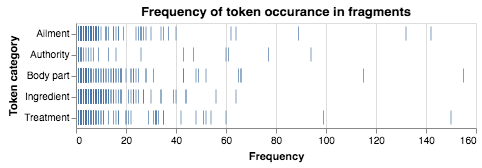

In [16]:
(alt.Chart(fragments_per_token, title='Frequency of token occurance in fragments')
  .mark_tick()
  .encode(
      alt.X('count:Q', title='Frequency'),
      alt.Y('type_display:N', title='Token category')
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
)

## Top Terms

Let's visualise the most frequently occuring terms using a Wordcloud. Terms are coloured according to category and sized according to number of fragments they appear in.

In [17]:
term_occurrences = (pd.merge(
        pd.DataFrame(fragment_tokens.groupby('token').aggregate('size'), columns=['occurrences']), 
        fragment_tokens[['token', 'type']].drop_duplicates(), 
        left_index=True, right_on='token')
    # Seems that Vega doesn't lay out the word cloud correctly if the text field isn't called "text".
    # Perhaps there's a default value referencing the text field, but I couldn't find one...
    .rename(columns={'token': 'text'}))
term_occurrences.text = term_occurrences.text.str.upper()
(term_occurrences.to_csv(chart_dir / 'vega-term-occurrences.csv', index=False))

(term_occurrences
     .sort_values(['occurrences', 'text'], ascending=False)
     .head())

,occurrences,text,type
1377,155,EYE,body_part
467,150,MEDICINE,treatment
563,142,DISEASE,ailment
43,132,FEVER,ailment
51,115,BODY,body_part


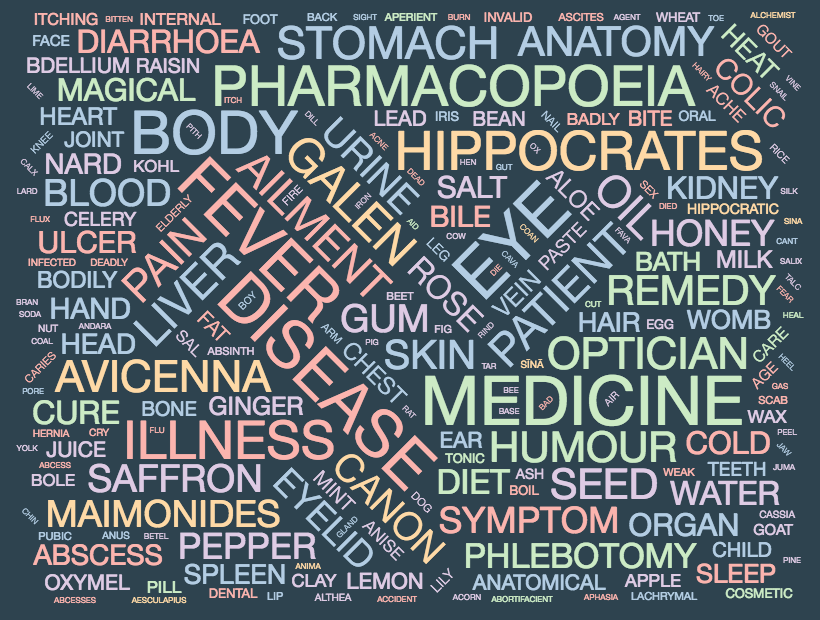

In [18]:
# Vega lite doesn't support word clouds, but Vega itself does, so we'll use that directly.

# Based on Vega's Word Cloud example: https://vega.github.io/vega/examples/word-cloud/
def term_occurrences_wordcloud_json(*, base_path):
    return {
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "width": 800,
  "height": 600,
  "padding": 10,
  "config": {
    "background": "#2e434f"  
  },
  "data": [
    {
      "name": "term-occurrences", 
      "url": str(chart_dir.relative_to(base_path) / "vega-term-occurrences.csv"),
      "format": {"type": "csv"},
      "transform": [
        {
          "type": "formula", "as": "angle",
          "expr": "[-45, 0, 45][round(random() * 3)]"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "term-occurrences", "field": "type"},
      "range": {"scheme": "pastel1"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "term-occurrences"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "type"}
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.65}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [800, 600],
          "text": {"field": "text"},
          "rotate": {"field": "datum.angle"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.occurrences"},
          "fontSizeRange": [8, 56],
          "padding": 2
        }
      ]
    }
  ]
}

wc = Vega(term_occurrences_wordcloud_json(base_path='.'))

save_vega_spec(spec=term_occurrences_wordcloud_json(base_path=chart_dir), 
               filename=str(chart_dir / 'wordcloud.html'))
wc

### Top terms table

And in a less graphical way, we can simply list the most frequently appearing terms in each category.

### Token co-occurence

We wonder if analysing the co-occurance of terms will yield useful insights. I.e. the number of times that any 2 pairs of tokens are used to describe the same fragment. For example, perhaps a particular ingredient is frequently used in the treatment of a certain ailment.

In [19]:
co = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co = co[co['token_x'] != co['token_y']]

co_canonical = co[['token_x', 'token_y']].reset_index().melt(id_vars=['index']).sort_values(['index', 'value']).set_index('index')[['value']]
co['token_x'], co['token_y'] = co_canonical[::2], co_canonical[1::2]

display(co.head(), co.tail())

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,headache,pharmacopoeia
2,MS-OR-01080-00001-00063,pharmacopoeia,urine
3,MS-OR-01080-00001-00063,pharmacopoeia,toothache
4,MS-OR-01080-00001-00063,facial,pharmacopoeia
5,MS-OR-01080-00001-00063,palsy,pharmacopoeia


,classmark,token_x,token_y
75835,MS-TS-AS-00182-00197,feverish,shivering
75838,MS-TS-AS-00111-00229,ash,medical-pharmaceutical
75839,MS-TS-AS-00111-00229,ash,medical-pharmaceutical
75851,MS-TS-AS-00156-00216,mutibb,weakening
75852,MS-TS-AS-00156-00216,mutibb,weakening


In [20]:
co_occurrences = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co_occurrences = co_occurrences[co_occurrences['token_x'] != co_occurrences['token_y']]

# Only count a token pair once for a document. This is done by canonicalising 
# the pairs by making token_x < token_y lexicographically and then dropping
# duplicates.
co_oc_canonical = (co_occurrences[['token_x', 'token_y']]
                   .reset_index()
                   .melt(id_vars=['index'])
                   .sort_values(['index', 'value'])
                   .set_index('index')
                   [['value']])
co_occurrences['token_x'], co_occurrences['token_y'] = co_canonical[::2], co_canonical[1::2]
co_occurrences = co_occurrences.drop_duplicates()

display(co_occurrences.head(), co_occurrences.tail())

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,headache,pharmacopoeia
2,MS-OR-01080-00001-00063,pharmacopoeia,urine
3,MS-OR-01080-00001-00063,pharmacopoeia,toothache
4,MS-OR-01080-00001-00063,facial,pharmacopoeia
5,MS-OR-01080-00001-00063,palsy,pharmacopoeia


,classmark,token_x,token_y
75817,MS-TS-AS-00184-00343,armpit,treated
75826,MS-TS-AS-00158-00024,dentist,nutrition
75834,MS-TS-AS-00182-00197,feverish,shivering
75838,MS-TS-AS-00111-00229,ash,medical-pharmaceutical
75851,MS-TS-AS-00156-00216,mutibb,weakening


In [21]:
co_oc_counts = (co_occurrences
                .groupby(['token_x', 'token_y'])
                .size()
                .reset_index()
                .rename(columns={0: 'count'})
                .sort_values('count', ascending=False))

# Add types
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_x'}), 
                          left_on='token_x', right_index=True, how='left')
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_y'}), 
                          left_on='token_y', right_index=True, how='left')
display(co_oc_counts.head(), co_oc_counts.tail())

,token_x,token_y,count,type_x,type_y
1085,al-kaḥḥālīn,optician,58,authority,treatment
3296,avicenna,medicine,52,authority,treatment
6324,canon,medicine,47,authority,treatment
3214,avicenna,canon,47,authority,authority
11701,eye,ophthalmology,29,body_part,treatment


,token_x,token_y,count,type_x,type_y
7366,childbirth,overweight,1,ailment,ailment
7365,childbirth,oil,1,ailment,ingredient
7364,childbirth,obstetrics,1,ailment,treatment
7363,childbirth,headache,1,ailment,ailment
20609,wound,yellow,1,ailment,ingredient


In [22]:
(co_oc_counts['count'] > 10).sum()

33

We'll try visualising co-occurances as a 2D heatmap.

This doesn't seem to provide a particulaly intuitive visualisation, as the data is quite sparse and it's hard to see which pair of terms a particular cell represents.

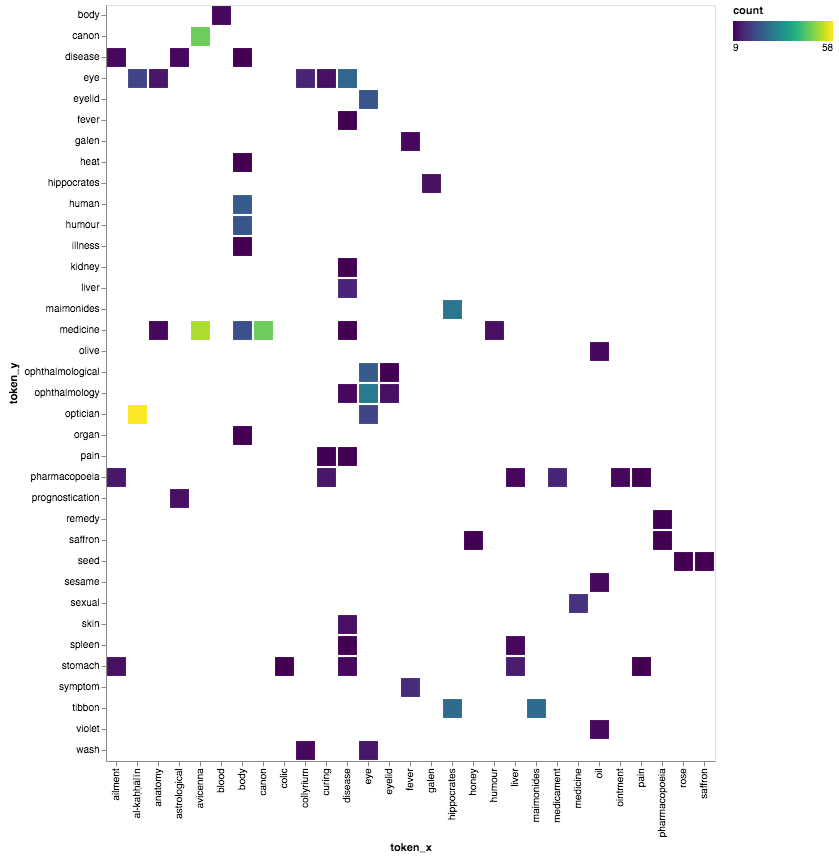

In [23]:
alt.Chart(co_oc_counts[co_oc_counts['count'] > 8]).mark_rect().encode(
    x='token_x:N',
    y='token_y:N',
    color='count:Q'
)

#### Edge bundling

An alternative approach to visualising co-occurance is to link co-occuring terms with lines. Hierarchical edge bundling is a method of reducing line overlap, to allow relationships to be more easilly seen.

In [24]:
import re

def drop_column_suffix(name):
    return re.sub(r'(_[a-z]+)?$', '', name)

In [25]:
co_oc_counts.head()

,token_x,token_y,count,type_x,type_y
1085,al-kaḥḥālīn,optician,58,authority,treatment
3296,avicenna,medicine,52,authority,treatment
6324,canon,medicine,47,authority,treatment
3214,avicenna,canon,47,authority,authority
11701,eye,ophthalmology,29,body_part,treatment


In [26]:
# We're going to organise tokens hierachically by category. Using Vega's nest transform
# would seem to be easiest, but it doesn't seem to provide a way to specify node IDs, which
# we need in order to provide the co-occurance relationships. Instead we'll have to provide
# a list of nodes with parent pointers and use the stratisfy transform to produce a tree.

eb_nodes = pd.DataFrame([{'parent': None, 'label': 'root', 'type': 'root'}])

# The pairs we'll include in the visualisation
eb_pairs = co_oc_counts[co_oc_counts['count'] > 6]

eb_leaves = pd.concat(
    [eb_pairs[['token_x', 'type_x']].rename(columns=drop_column_suffix), 
     eb_pairs[['token_y', 'type_y']].rename(columns=drop_column_suffix)]
).drop_duplicates()

_type_nodes = eb_leaves[['type']].drop_duplicates().rename(columns={'type': 'label'})
_type_nodes['parent'] = eb_nodes.iloc[0].name
_type_nodes['type'] = 'category'

eb_nodes = pd.concat([eb_nodes, _type_nodes], ignore_index=True)

eb_leaf_nodes = (
    pd.merge(eb_leaves, 
         eb_nodes[eb_nodes['type'] == 'category'].reset_index()[['index', 'label']], 
         left_on='type', right_on='label')
    [['token', 'index']]
    .rename(columns={'token': 'label', 'index': 'parent'}))
eb_leaf_nodes['type'] = 'token'
eb_leaf_nodes

eb_nodes = pd.concat([eb_nodes, eb_leaf_nodes], ignore_index=True)
eb_nodes.head(10)

,label,parent,type
0,root,None,root
1,authority,0,category
2,body_part,0,category
3,ailment,0,category
4,treatment,0,category
5,ingredient,0,category
6,al-kaḥḥālīn,1,token
7,avicenna,1,token
8,canon,1,token
9,hippocrates,1,token


In [27]:
# We need to give Vega data on the relationships between nodes - the co-occurance frequencies.
# Our links are symmetrical, so we create links in both directions with the same counts.
eb_links_forward = (
    eb_pairs[['token_x', 'token_y', 'count']]
        .rename(columns={'token_x': 'source', 'token_y': 'target'})
        .reset_index(drop=True))
eb_links_backward = (
    eb_links_forward.rename(columns={'source': 'target', 'target': 'source'})
        [['source', 'target', 'count']])

_token_ids = eb_nodes[eb_nodes['type'] == 'token'][['label']].reset_index().set_index('label')

eb_links = pd.concat([
    eb_links_forward, 
#     eb_links_backward
]).sort_index()
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'source_id'), left_on='source', right_index=True)
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'target_id'), left_on='target', right_index=True)
eb_links_ids = eb_links[['source_id', 'target_id', 'count']]

eb_links.head()

,source,target,count,source_id,target_id
0,al-kaḥḥālīn,optician,58,6,54
15,eye,optician,19,14,54
80,eyelid,optician,8,18,54
14,al-kaḥḥālīn,eye,19,6,14
8,disease,eye,25,30,14


In [28]:
# Create data files for Vega
(eb_nodes
 # Vega expects an id property to identify tree nodes
 .reset_index()
 .to_json('./vega-co-occurance-tree-nodes.json', orient='records'))

eb_links_ids.to_json('./vega-co-occurance-relationships.json', orient='records')

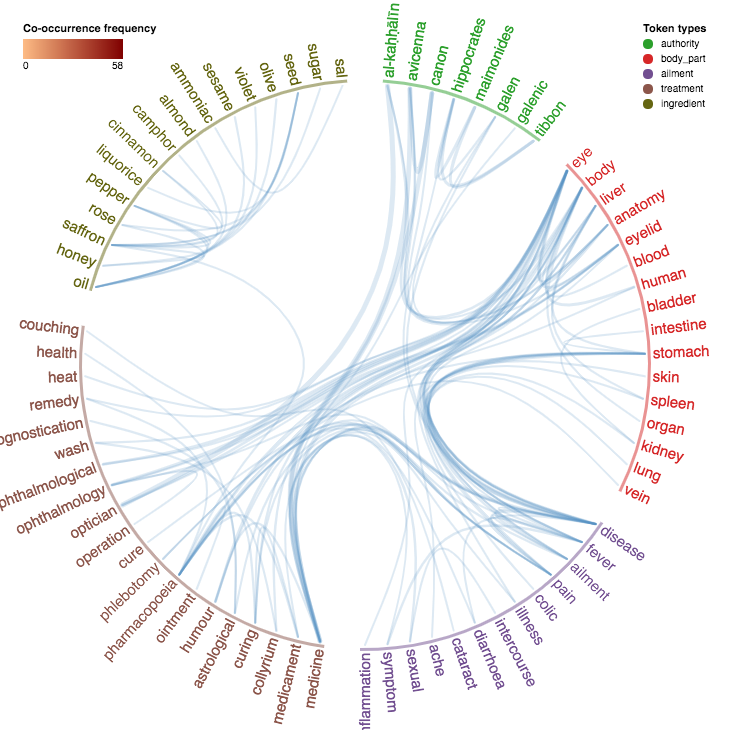

In [29]:
import json

vega_radial_co_occurance_json = {
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "padding": 5,
  "width": 720,
  "height": 720,
  "autosize": "none",

  "signals": [
    {
      "name": "tension", "value": 0.85,
#       "bind": {"input": "range", "min": 0, "max": 1, "step": 0.01}
    },
    {
      "name": "radius", "value": 280,
#       "bind": {"input": "range", "min": 20, "max": 400}
    },
    {
      "name": "extent", "value": 360,
#       "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate", "value": 0,
#       "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "textSize", "value": 15,
#       "bind": {"input": "range", "min": 2, "max": 20, "step": 1}
    },
    {
      "name": "textOffset", "value": 8,
#       "bind": {"input": "range", "min": 0, "max": 16, "step": 1}
    },
    {
      "name": "layout", "value": "cluster",
#       "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    { "name": "colorIn", "value": "forestgreen" },
    { "name": "colorOut", "value": "forestgreen" },
    { "name": "originX", "update": "width / 2" },
    { "name": "originY", "update": "height / 2" },
    {
      "name": "active", "value": None,
      "on": [
        { "events": "text:mouseover", "update": "datum.index" },
        { "events": "mouseover[!event.item]", "update": "null" }
      ]
    }
  ],

  "data": [
    {
      "name": "tree",
      #"url": "vega-co-occurance-leaf-nodes.json",
      "values": json.loads(eb_nodes.reset_index()
                         .to_json(orient='records')),
      "transform": [
        {
          "type": "stratify",
          "key": "index",
          "parentKey": "parent"
        },
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, 1],
          "as": ["alpha", "beta", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as":   "angle"
        },
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as":   "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + radius * datum.beta * cos(PI * datum.angle / 180)",
          "as":   "x"
        },
        {
          "type": "formula",
          "expr": "originY + radius * datum.beta * sin(PI * datum.angle / 180)",
          "as":   "y"
        }
      ]
    },
    {
      "name": "dependencies",
      #"url": "vega-co-occurance-relationships.json",
      "values": json.loads(eb_links_ids.to_json(orient='records')),
      "transform": [
        {
          "type": "formula",
          "expr": "treePath('tree', datum.source_id, datum.target_id)",
          "as":   "treepath",
          "initonly": True
        },
        {
          "type": "formula",
          "as": "is_active",
          "expr": "datum.source_id === active || datum.target_id === active"
        }
      ]
    },
    {
      "name": "selected_links",
      "source": "dependencies",
      "transform": [
        {
          "type": "filter",
          "expr": "datum.is_active"
        }
      ]
    },
    {
      "name": "unselected_links",
      "source": "dependencies",
      "transform": [
        {
          "type": "filter",
          "expr": "!datum.is_active"
        }
      ]
    },
    {
      "name": "leaves",
      "source": "tree",
      "transform": [
        {
          "type": "filter",
          "expr": "!datum.children"
        },
        {
          "type": "lookup",
          "from": "tree",
          "key": "index",
          "fields": ["parent"],
          "values": ["label"],
          "as": ["group_label"]
        },
        {
          "type": "lookup",
          "from": "selected_links",
          "key": "source_id",
          "fields": ["index"],
          "values": ["count"],
          "as": ["count_src"]
        },
        {
          "type": "lookup",
          "from": "selected_links",
          "key": "target_id",
          "fields": ["index"],
          "values": ["count"],
          "as": ["count_dst"]
        },
        {
          "type": "formula",
          "as": "selected_count",
          "expr": "datum.count_src || datum.count_dst"
        },
        {
          "type": "formula",
          "as": "label_with_count",
          "expr": "datum.label + if(isNumber(datum.selected_count), \" (\" + datum.selected_count + \")\", \"\")"
        }
      ]
    },
    {
      "name": "token_groups",
      "source": "leaves",
      "transform": [
        {
          "type": "aggregate",
          "groupby": ["group_label"],
          "fields": ["alpha", "alpha"],
          "ops": ["min", "max"],
          "as": ["start_alpha", "end_alpha"]
        },
        {
          "type": "formula",
          "expr": "rotate + extent * datum.start_alpha",
          "as":   "start_angle_deg"
        },
        {
          "type": "formula",
          "expr": "rotate + extent * datum.end_alpha",
          "as":   "end_angle_deg"
        },
        {
          "type": "formula",
          "expr": "(PI * (rotate + extent * datum.start_alpha) / 180)",
          "as":   "start_angle"
        },
        {
          "type": "formula",
          "expr": "(PI * (rotate + extent * datum.end_alpha) / 180)",
          "as":   "end_angle"
        }
      ]
    }
  ],

  "marks": [
    {
      "type": "arc",
      "from": {"data": "token_groups"},
      "encode": {
        "enter": {
          "x": {"signal": "originX"},
          "y": {"signal": "originY"},
          "fill": {"scale": "token_type", "field": "group_label"},
          "outerRadius": {"signal": "radius + 6"},
          "innerRadius": {"signal": "radius + 3"},
          "fillOpacity": {"value": 0.5},
          "tooltip": {"field": "group_label"},
        },
        "update": {
          "startAngle": {"signal": "datum.start_angle - (PI * (extent / 360) / 180)"},
          "endAngle": {"signal": "datum.end_angle + (PI * (extent / 360) / 180)"},
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "leaves"},
      "encode": {
        "enter": {
          "baseline": {"value": "middle"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "textOffset * (datum.leftside ? -1 : 1)"},
          "angle": {"signal": "datum.leftside ? datum.angle - 180 : datum.angle"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "fontSize": {"signal": "textSize"},
          "fontWeight": [
            {"value": None}
          ],
          "fill": [
              {"test": "indata('selected_links', 'source_id', datum.index)", "scale": "colour2", "field": "selected_count"},
              {"scale": "token_type", "field": "group_label"}
          ],
          "opacity": [
            {"test": "indata('selected_links', 'source_id', datum.index)", "value": 1},
            {"test": "indata('selected_links', 'target_id', datum.index)", "value": 1},
            {"test": "active !== null", "value": 0.4},
            {"value": 1}
          ],
          "text": [
              {"test": "datum.index === active", "field": "label"},
              {"field": "label_with_count"}
          ]
        }
      }
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name":  "path",
          "data":  "selected_links",
          "field": "treepath"
        }
      },
      "zindex": 1,
      "marks": [
        {
          "type": "line",
          "interactive": False,
          "from": {"data": "path"},
          "encode": {
            "enter": {
              "interpolate": {"value": "bundle"},
              "strokeWidth": {"scale": "strokeSize", "field": {"parent": "count"}},
              "strokeCap": {"value": "round"},
            },
            "update": {
              "stroke": {"scale": "colour2", "field": {"parent": "count"}},
              "strokeOpacity": [
                {"value": 0.6}
              ],
              "tension": {"signal": "tension"},
              "x": {"field": "x"},
              "y": {"field": "y"}
            }
          }
        }
      ]
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name":  "path",
          "data":  "unselected_links",
          "field": "treepath"
        }
      },
      "zindex": 0,
      "marks": [
        {
          "type": "line",
          "interactive": False,
          "from": {"data": "path"},
          "encode": {
            "enter": {
              "interpolate": {"value": "bundle"},
              "strokeWidth": {"scale": "strokeSize", "field": {"parent": "count"}},
              "strokeCap": {"value": "round"},
            },
            "update": {
              "stroke": {"value": "#538fc1"},
              "strokeOpacity": [
                  {"test": "active !== null", "value": 0.05},
                  {"value": 0.2}
              ],
              "tension": {"signal": "tension"},
              "x": {"field": "x"},
              "y": {"field": "y"}
            }
          }
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": ["depends on", "imported by"],
      "range": [{"signal": "colorIn"}, {"signal": "colorOut"}]
    },
    {
      "name": "colour2",
      "type": "linear",
      "domain": {"data": "dependencies", "field": "count"},
      "range": ["#fdbb84", "#7f0000"]
    },
    {
      "name": "strokeSize",
      "type": "linear",
      "zero": True,
      "domain": {"data": "dependencies", "field": "count"},
      "range": [1.5, 5]
    },
    {
      "name": "token_type",
      "type": "ordinal",
      "domain": {"data": "token_groups", "field": "group_label"},
      "range": ["#2ca02c", "#d62728", "#724F91", "#8c564b", "#656612"]
    }
  ],

  "legends": [
    {
      "fill": "colour2",
      "type": "gradient",
      "orient": "top-left",
      "title": "Co-occurrence frequency",
    },
    {
      "fill": "token_type",
      "type": "symbol",
      "orient": "top-right",
      "title": "Token types",
    }
  ]
}


save_vega_spec(spec=vega_radial_co_occurance_json, 
               filename=str(chart_dir / 'radial-co-occurance.html'), embed_options={'width': 720, 'height': 720})
alt.vega.v3.vega(vega_radial_co_occurance_json)